# Frontal Detection Analysis (front crossing rates) - exploring the data

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib import cm
import matplotlib as mpl
import cartopy.feature as cfeature

## CESM historial simulation front rates

In [4]:
cesm_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
cesm_hist_rates_file = "cesm_frontRates_2000-2005.nc"

In [6]:
cesm_hist_rates_fronts = xr.open_dataset(cesm_filepath+cesm_hist_rates_file)

In [7]:
cesm_hist_rates_fronts

<xarray.Dataset>
Dimensions:                          (bnds: 2, front: 5, lat: 68, lon: 141, months: 72, months12: 12, seasons: 25, seasons4: 4, total: 1, years: 6)
Coordinates:
  * lat                              (lat) float64 10.0 11.0 12.0 ... 76.0 77.0
  * lon                              (lon) float64 189.0 190.0 ... 328.0 329.0
  * months                           (months) object 2000-01-15 00:00:00 ... 2005-12-15 00:00:00
    clim_months                      (months12) object ...
  * seasons                          (seasons) object 2000-01-15 00:00:00 ... 2005-12-15 00:00:00
    clim_seasons                     (seasons4) object ...
  * years                            (years) object 2000-07-15 00:00:00 ... 2005-07-15 00:00:00
    front_type                       (front) object ...
Dimensions without coordinates: bnds, front, months12, seasons4, total
Data variables:
    month_bounds                     (months, bnds) object ...
    clim_month_bounds                (months12, bnds) float64 ...
    season_bounds                    (seasons, bnds) object ...
    clim_season_bounds               (seasons4, bnds) float64 ...
    year_bounds                      (years, bnds) object ...
    total_time                       (total) object ...
    total_time_bounds                (total, bnds) object ...
    monthly_rate                     (months, front, lat, lon) float32 ...
    monthly_rate_anomaly             (months, front, lat, lon) float32 ...
    monthly_rate_climatology         (months12, front, lat, lon) float32 ...
    monthly_rate_climatology_stdev   (months12, front, lat, lon) float32 ...
    seasonal_rate                    (seasons, front, lat, lon) float32 ...
    seasonal_rate_anomaly            (seasons, front, lat, lon) float32 ...
    seasonal_rate_climatology        (seasons4, front, lat, lon) float32 ...
    seasonal_rate_climatology_stdev  (seasons4, front, lat, lon) float32 ...
    annual_rate                      (years, front, lat, lon) float32 ...
    annual_rate_anomaly              (years, front, lat, lon) float32 ...
    total_rate                       (total, front, lat, lon) float32 ...
    total_rate_stdev                 (total, front, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        Monthly, Annual, and Mean Frontal Boundary Crossing Rates
    summary:      This file contains grids showing rates of frontal boundary ...

In [8]:
# seasonal centers? i.e., DJF center is Jan 15?
cesm_hist_rates_fronts.clim_seasons

<xarray.DataArray 'clim_seasons' (seasons4: 4)>
array([cftime.DatetimeNoLeap(2003, 1, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2003, 4, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2003, 7, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2003, 10, 15, 0, 0, 0, 0)], dtype=object)
Coordinates:
    clim_seasons  (seasons4) object 2003-01-15 00:00:00 ... 2003-10-15 00:00:00
Dimensions without coordinates: seasons4
Attributes:
    axis:           T
    long_name:      climatology seasons
    standard_name:  time
    climatology:    clim_season_bounds

In [9]:
# last front index is "all"
cesm_hist_rates_fronts.front_type

<xarray.DataArray 'front_type' (front: 5)>
array(['cold', 'warm', 'stationary', 'occluded', 'all'], dtype=object)
Coordinates:
    front_type  (front) object 'cold' 'warm' 'stationary' 'occluded' 'all'
Dimensions without coordinates: front
Attributes:
    long_name:  kind of front

In [10]:
# seasonal rate climo
cesm_hist_srates_clim = cesm_hist_rates_fronts.seasonal_rate_climatology

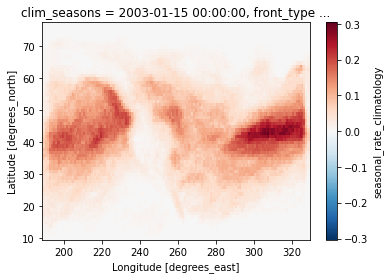

In [11]:
# how different is the sum of the front types versus the 'all' front type?
diffcheck = cesm_hist_srates_clim[:,:4,:,:].sum('front') - cesm_hist_srates_clim[:,4,:,:]
diffcheck[0,:,:].plot();

In [12]:
# CONUS region
cesm_hist_srates_clim_CONUS = cesm_hist_srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons

In [13]:
# weighted spatial mean
weights = np.cos(np.deg2rad(cesm_hist_srates_clim_CONUS.lat))
weights.name = "weights"
cesm_hist_srates_clim_CONUS_weighted = cesm_hist_srates_clim_CONUS.weighted(weights)
cesm_hist_srates_clim_CONUS_weighted_mean_wk = cesm_hist_srates_clim_CONUS_weighted.mean(("lon","lat"))*7 # convert counts/day to counts/wk

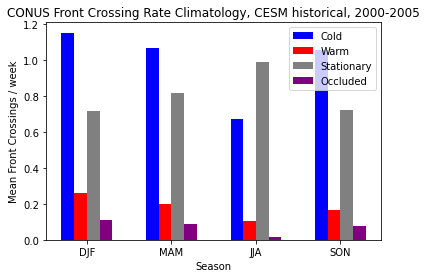

In [14]:
# plot front rates by type
fig, ax = plt.subplots()

w = 0.15
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nseason)/2) + 0*w
ax.bar(position, cesm_hist_srates_clim_CONUS_weighted_mean_wk[:,0], width=w, label="Cold", color='blue')
position = x + (w*(1-nseason)/2) + 1*w
ax.bar(position, cesm_hist_srates_clim_CONUS_weighted_mean_wk[:,1], width=w, label="Warm", color='red')
position = x + (w*(1-nseason)/2) + 2*w
ax.bar(position, cesm_hist_srates_clim_CONUS_weighted_mean_wk[:,2], width=w, label="Stationary", color='grey')
position = x + (w*(1-nseason)/2) + 3*w
ax.bar(position, cesm_hist_srates_clim_CONUS_weighted_mean_wk[:,3], width=w, label="Occluded", color='purple')

ax.set_title('CONUS Front Crossing Rate Climatology, CESM historical, 2000-2005')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

#plt.savefig('../figures/cesm_hist_srates_clim_CONUS_mean_wk_viaOH.png') # Note: these are rates via one-hots

## CESM continuation: RCP2.6, 2006-2015

In [15]:
cesm_rcp_rates_file = "cesm_frontRates_2006-2015.nc"

In [16]:
cesm_rcp_rates_fronts = xr.open_dataset(cesm_filepath+cesm_rcp_rates_file)

In [17]:
cesm_rcp_srates_clim = cesm_rcp_rates_fronts.seasonal_rate_climatology
cesm_rcp_srates_clim_CONUS = cesm_rcp_srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
cesm_rcp_srates_clim_CONUS_weighted = cesm_rcp_srates_clim_CONUS.weighted(weights)
cesm_rcp_srates_clim_CONUS_weighted_mean_wk = cesm_rcp_srates_clim_CONUS_weighted.mean(("lon","lat"))*7 # convert counts/day to counts/wk

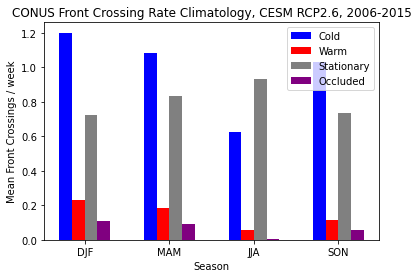

In [18]:
# plot front rates by type
fig, ax = plt.subplots()

w = 0.15
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nseason)/2) + 0*w
ax.bar(position, cesm_rcp_srates_clim_CONUS_weighted_mean_wk[:,0], width=w, label="Cold", color='blue')
position = x + (w*(1-nseason)/2) + 1*w
ax.bar(position, cesm_rcp_srates_clim_CONUS_weighted_mean_wk[:,1], width=w, label="Warm", color='red')
position = x + (w*(1-nseason)/2) + 2*w
ax.bar(position, cesm_rcp_srates_clim_CONUS_weighted_mean_wk[:,2], width=w, label="Stationary", color='grey')
position = x + (w*(1-nseason)/2) + 3*w
ax.bar(position, cesm_rcp_srates_clim_CONUS_weighted_mean_wk[:,3], width=w, label="Occluded", color='purple')

ax.set_title('CONUS Front Crossing Rate Climatology, CESM RCP2.6, 2006-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

#plt.savefig('../figures/cesm_rcp_srates_clim_CONUS_mean_wk_viaOH.png') # Note: these are rates via one-hots

## Validation data: Coded Surface Bulletin fronts

In [21]:
csb_filepath = "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/"
csb_rates_file = "codsus_frontRates_2003-2015.nc" # unmasked version to compare with CESM/MERRA
#csb_rates_file = "codsus_masked_frontRates_2003-2015.nc" # masked version to compare with Jim's analysis
# NOTE: masking is really just cutting out extreme SW US which doesn't have that many fronts anyway, so the CONUS averages should look similar for CSB masked/unmasked
#csb_rates_file = "codsus_1wide_frontRates_2003-2015.nc" # testing the 1wide version - makes a big difference!

In [22]:
csb_rates_fronts = xr.open_dataset(csb_filepath+csb_rates_file)

In [23]:
csb_srates_clim = csb_rates_fronts.seasonal_rate_climatology

In [24]:
# approx. lat/lon here to get a CONUS rectangular region
csb_srates_clim_CONUS = csb_srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons

In [25]:
weights = np.cos(np.deg2rad(csb_srates_clim_CONUS.lat))
weights.name = "weights"
csb_srates_clim_CONUS_weighted = csb_srates_clim_CONUS.weighted(weights)
csb_srates_clim_CONUS_weighted_mean_wk = csb_srates_clim_CONUS_weighted.mean(("lon","lat"))*7

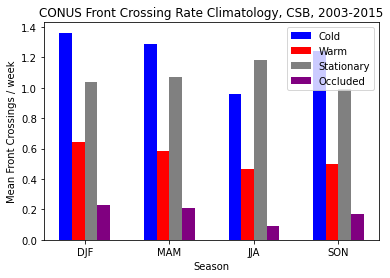

In [26]:
fig, ax = plt.subplots()

w = 0.15
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nseason)/2) + 0*w
ax.bar(position, csb_srates_clim_CONUS_weighted_mean_wk[:,0], width=w, label="Cold", color='blue')
position = x + (w*(1-nseason)/2) + 1*w
ax.bar(position, csb_srates_clim_CONUS_weighted_mean_wk[:,1], width=w, label="Warm", color='red')
position = x + (w*(1-nseason)/2) + 2*w
ax.bar(position, csb_srates_clim_CONUS_weighted_mean_wk[:,2], width=w, label="Stationary", color='grey')
position = x + (w*(1-nseason)/2) + 3*w
ax.bar(position, csb_srates_clim_CONUS_weighted_mean_wk[:,3], width=w, label="Occluded", color='purple')

ax.set_title('CONUS Front Crossing Rate Climatology, CSB, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

#plt.savefig('../figures/csb_srates_clim_CONUS_mean_wk.png')
#plt.savefig('../figures/csb_masked_srates_clim_CONUS_mean_wk.png')
#plt.savefig('../figures/csb_1wide_srates_clim_CONUS_mean_wk.png')

## Combine CESM output 2003-2015 to compare with the same obs years

In [5]:
#cesm_rates_file = "cesm_frontRates_2003-2015.nc"
cesm_rates_file = "cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc" # rates calculated via polyline analysis (to better compare to Jim's analysis)
cesm_rates_fronts = xr.open_dataset(cesm_filepath+cesm_rates_file)

In [6]:
cesm_srates_clim = cesm_rates_fronts.seasonal_rate_climatology
#cesm_srates_clim_CONUS = cesm_srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
cesm_srates_clim_CONUS = cesm_srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # used MERRA2 grid lons for rates calculated via polylines
weights = np.cos(np.deg2rad(cesm_srates_clim_CONUS.lat))
weights.name = "weights"
cesm_srates_clim_CONUS_weighted = cesm_srates_clim_CONUS.weighted(weights)
cesm_srates_clim_CONUS_weighted_mean_wk = cesm_srates_clim_CONUS_weighted.mean(("lon","lat"))*7

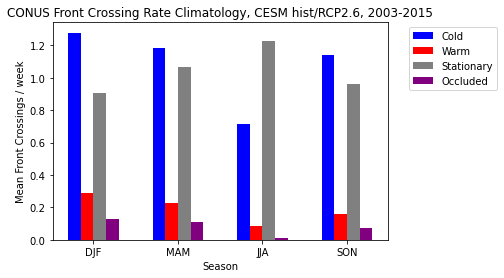

In [10]:
fig, ax = plt.subplots()

w = 0.15
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nseason)/2) + 0*w
ax.bar(position, cesm_srates_clim_CONUS_weighted_mean_wk [:,0], width=w, label="Cold", color='blue')
position = x + (w*(1-nseason)/2) + 1*w
ax.bar(position, cesm_srates_clim_CONUS_weighted_mean_wk [:,1], width=w, label="Warm", color='red')
position = x + (w*(1-nseason)/2) + 2*w
ax.bar(position, cesm_srates_clim_CONUS_weighted_mean_wk [:,2], width=w, label="Stationary", color='grey')
position = x + (w*(1-nseason)/2) + 3*w
ax.bar(position, cesm_srates_clim_CONUS_weighted_mean_wk [:,3], width=w, label="Occluded", color='purple')

ax.set_title('CONUS Front Crossing Rate Climatology, CESM hist/RCP2.6, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));

#plt.savefig('../figures/toSCP/cesm_srates_clim_CONUS_mean_wk_viaPoly.png', bbox_inches='tight')

### Spatial Maps of Seasonal Climatology

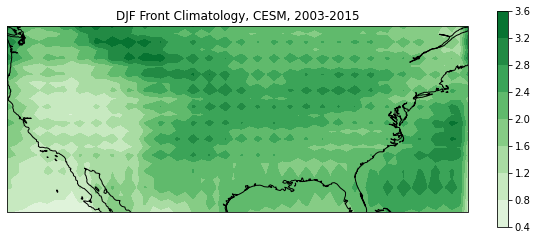

In [32]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

# start with the first season (DJF)
field, lon = add_cyclic_point((cesm_srates_clim_CONUS*7)[0,4,:,:], coord=cesm_srates_clim_CONUS.lon)
lat = cesm_srates_clim_CONUS.lat

cf = ax.contourf(lon, lat, field, vmin=0, vmax=4, cmap=cm.Greens, transform=ccrs.PlateCarree())
#cf = ax.pcolormesh(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation

ax.set_title('DJF Front Climatology, CESM, 2003-2015')
ax.coastlines()

plt.colorbar(cf, shrink=0.5);

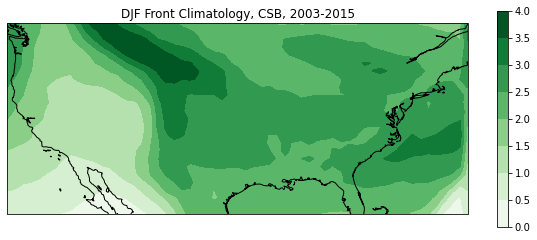

In [33]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

# start with the first season (DJF)
field, lon = add_cyclic_point((csb_srates_clim_CONUS*7)[0,4,:,:], coord=csb_srates_clim_CONUS.lon)
lat = csb_srates_clim_CONUS.lat

cf = ax.contourf(lon, lat, field, vmin=0, vmax=4, cmap=cm.Greens, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation
ax.set_title('DJF Front Climatology, CSB, 2003-2015')
ax.coastlines()

plt.colorbar(cf, shrink=0.5);

# compare masked and unmasked CSB data to see the difference spatially
#plt.savefig('../figures/csb_srates_clim_DJF.png')
#plt.savefig('../figures/csb_masked_srates_clim_DJF.png')

## MERRA data

In [11]:
merra_file_path = "/glade/work/kdagon/FrontDetector/MERRAOutputs/"
merra_rates_file = "merra_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc" # rates calculated via polyline analysis (to better compare to Jim's analysis)
merra_rates_fronts = xr.open_dataset(merra_file_path+merra_rates_file)

In [12]:
merra_srates_clim = merra_rates_fronts.seasonal_rate_climatology
merra_srates_clim_CONUS = merra_srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # used MERRA2 grid lons for rates calculated via polylines
merra_srates_clim_CONUS_mean_wk = merra_srates_clim_CONUS.mean(("lon","lat"))*7 # convert counts/day to counts/wk

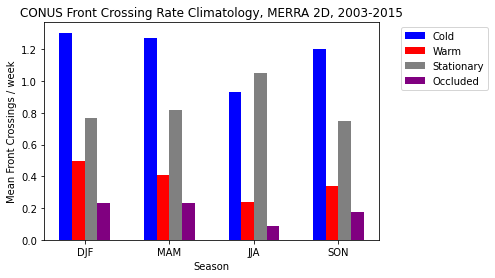

In [14]:
fig, ax = plt.subplots()

w = 0.15
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nseason)/2) + 0*w
ax.bar(position, merra_srates_clim_CONUS_mean_wk [:,0], width=w, label="Cold", color='blue')
position = x + (w*(1-nseason)/2) + 1*w
ax.bar(position, merra_srates_clim_CONUS_mean_wk [:,1], width=w, label="Warm", color='red')
position = x + (w*(1-nseason)/2) + 2*w
ax.bar(position, merra_srates_clim_CONUS_mean_wk [:,2], width=w, label="Stationary", color='grey')
position = x + (w*(1-nseason)/2) + 3*w
ax.bar(position, merra_srates_clim_CONUS_mean_wk [:,3], width=w, label="Occluded", color='purple')

ax.set_title('CONUS Front Crossing Rate Climatology, MERRA 2D, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));

In [15]:
# error bars
merra_srates_clim_stdev = merra_rates_fronts.seasonal_rate_climatology_stdev
merra_srates_clim_stdev_CONUS = merra_srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
merra_srates_clim_stdev_CONUS_mean_wk = merra_srates_clim_stdev_CONUS.mean(("lon","lat"))*7
merra_srates_clim_stdev_CONUS_mean_wk[:,4]

<xarray.DataArray 'seasonal_rate_climatology_stdev' (seasons4: 4)>
array([0.36066693, 0.34251338, 0.31526452, 0.2864061 ], dtype=float32)
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] ...
    front_type    object ...
Dimensions without coordinates: seasons4

In [16]:
merra_cesm_rates_file = "merra_cesm_fronts_2000-2015_frontRates_viaPolylines_customgrid.nc" # rates calculated via polyline analysis (to better compare to Jim's analysis)
#merra_cesm_rates_file = "merra_cesm_frontRates_2000-2015.nc" # rates calculated via OneHot file
merra_cesm_rates_fronts = xr.open_dataset(merra_file_path+merra_cesm_rates_file)

In [17]:
merra_cesm_srates_clim = merra_cesm_rates_fronts.seasonal_rate_climatology
merra_cesm_srates_clim_CONUS = merra_cesm_srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # used MERRA2 grid lons for rates calculated via polylines
#merra_cesm_srates_clim_CONUS = merra_cesm_srates_clim.sel(lat=slice(26,50), lon=slice(235,292))
merra_cesm_srates_clim_CONUS_mean_wk = merra_cesm_srates_clim_CONUS.mean(("lon","lat"))*7 # convert counts/day to counts/wk

In [18]:
# error bars
merra_cesm_srates_clim_stdev = merra_cesm_rates_fronts.seasonal_rate_climatology_stdev
merra_cesm_srates_clim_stdev_CONUS = merra_cesm_srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
#merra_cesm_srates_clim_stdev_CONUS = merra_cesm_srates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
merra_cesm_srates_clim_stdev_CONUS_mean_wk = merra_cesm_srates_clim_stdev_CONUS.mean(("lon","lat"))*7
merra_cesm_srates_clim_stdev_CONUS_mean_wk[:,4]

<xarray.DataArray 'seasonal_rate_climatology_stdev' (seasons4: 4)>
array([0.35078797, 0.33709604, 0.31716764, 0.3009299 ], dtype=float32)
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] ...
    front_type    object ...
Dimensions without coordinates: seasons4

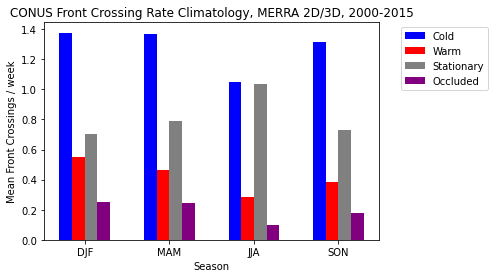

In [19]:
fig, ax = plt.subplots()

w = 0.15
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nseason)/2) + 0*w
ax.bar(position, merra_cesm_srates_clim_CONUS_mean_wk [:,0], width=w, label="Cold", color='blue')
position = x + (w*(1-nseason)/2) + 1*w
ax.bar(position, merra_cesm_srates_clim_CONUS_mean_wk [:,1], width=w, label="Warm", color='red')
position = x + (w*(1-nseason)/2) + 2*w
ax.bar(position, merra_cesm_srates_clim_CONUS_mean_wk [:,2], width=w, label="Stationary", color='grey')
position = x + (w*(1-nseason)/2) + 3*w
ax.bar(position, merra_cesm_srates_clim_CONUS_mean_wk [:,3], width=w, label="Occluded", color='purple')

ax.set_title('CONUS Front Crossing Rate Climatology, MERRA 2D/3D, 2000-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));